In [113]:
import pandas as pd
import numpy as np
import jieba
import re
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Embedding,SpatialDropout1D,LSTM,RNN,GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.model_selection import train_test_split

In [90]:
def removepre(sentence):
    pattern = re.compile("[^a-zA-Z0-9\u4E00-\u9FA5]")
    sentence = pattern.sub("",sentence)
    return sentence

def stopwordslist():
    stopwords = [line.strip() for line in open('cn_stopwords.txt',encoding='UTF-8').readlines()]
    stopwords.extend([line.strip() for line in open('scu_stopwords.txt',encoding='UTF-8').readlines()])
    stopwords.extend([line.strip() for line in open('baidu_stopwords.txt',encoding='UTF-8').readlines()])
    stopwords.extend([line.strip() for line in open('hit_stopwords.txt',encoding='UTF-8').readlines()])
    return stopwords

def seg_depart(sentence):
     # 对文档中的每一行进行中文分词
    sentence_depart = jieba.cut(sentence.strip())
     # 创建一个停用词列表
    stopwords = stopwordslist()
    # 输出结果为outstr
    outstr = ''
   # 去停用词
    for word in sentence_depart:
        if word not in stopwords:
            if word != '\t':
                outstr += word
                outstr += " "
    return outstr  

In [91]:
training = pd.read_csv("train.csv",delimiter="\t")
training.head()

,target,text,stance
0,开放二胎,刚回家几天就迫不及待的赶到了小舅家，看着乖巧懂事的表妹和可爱的小表弟，心情格外舒畅！这个画面不禁让我想到刚过去没多长时间的十八届五中全会，国家开放二胎政策，大家都有自己的想法。不过看着他们的笑脸，我心里默默肯定了这项政策。,FAVOR
1,俄罗斯在叙利亚的反恐行动,俄罗斯就是流氓,AGAINST
2,春节放鞭炮,#春节放鞭炮#【中央气象台首次发布烟花爆竹燃放气象指数】明天就是除夕了，年味越发浓郁。今早，中央气象台发布了国家级烟花爆竹燃放气象指数预报。预计1月29日白天到夜间，河北中南部、河南南部、湖北中东部、湖南西北部、四川盆地中南部等地的部分地区气象条件不适宜燃放烟花爆竹，请尽量不要燃放。,AGAINST
3,IphoneSE,iPhoneSE貌似摄像头不外突了，普天同庆,FAVOR
4,春节放鞭炮,千万人口级城市北京，原住民在庆祝第一大节日春节，大家伙都心照不宣的想到：别再给伤痕累累的家乡环境增加负担了。所以自觉少放或不放鞭炮烟花，而原博说的十万人口级的小县城，人为制造了一场雾霾天气。也好，这样充分说明了，贱射者是环境污染、社会秩序恶化的发生源，说它们是祸害是毒瘤绝对正确！,AGAINST


In [92]:
training["cleaned"] = training["text"].apply(removepre)
training["cut"] = training["cleaned"].apply(seg_depart)

In [136]:
from gensim.models import Word2Vec

In [137]:
model = Word2Vec.load("word2Vec.model")

In [94]:
MAX_NB_WORDS = 1000
# 每条cut_review最大的长度
MAX_SEQUENCE_LENGTH = 260
# 设置Embeddingceng层的维度
EMBEDDING_DIM = 100
 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(training["cut"].values)

word_index = tokenizer.word_index


In [95]:
len(word_index)

14886

In [96]:

X = tokenizer.texts_to_sequences(training["cut"].values)
#填充X,让X的各个列的长度统一
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
 
#多类标签的onehot展开
Y = pd.get_dummies(training["stance"]).values
 
print(X.shape)
print(Y.shape)


(2400, 260)
(2400, 3)


In [97]:

x_train, x_test, y_train, y_test = train_test_split(X,Y,random_state=1,test_size =0.2)

In [132]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(GRU(100,dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.optimizer.lr.assign(0.01)
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 260, 100)          100000    
_________________________________________________________________
gru_7 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 303       
Total params: 160,603
Trainable params: 160,603
Non-trainable params: 0
_________________________________________________________________
None


In [133]:
epochs = 10
batch_size = 32
 
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 1728 samples, validate on 192 samples
Epoch 1/10
1728/1728 [==============================] - 20s 12ms/step - loss: 1.0632 - acc: 0.4039 - val_loss: 1.0229 - val_acc: 0.4688
Epoch 2/10
1728/1728 [==============================] - 19s 11ms/step - loss: 0.9718 - acc: 0.5561 - val_loss: 1.0204 - val_acc: 0.4948
Epoch 3/10
1728/1728 [==============================] - 19s 11ms/step - loss: 0.7603 - acc: 0.6707 - val_loss: 1.0118 - val_acc: 0.5521
Epoch 4/10
1728/1728 [==============================] - 19s 11ms/step - loss: 0.5947 - acc: 0.7431 - val_loss: 1.1914 - val_acc: 0.5469
Epoch 5/10
1728/1728 [==============================] - 19s 11ms/step - loss: 0.4856 - acc: 0.8015 - val_loss: 1.4667 - val_acc: 0.5469
Epoch 6/10
1728/1728 [==============================] - 19s 11ms/step - loss: 0.4032 - acc: 0.8409 - val_loss: 1.6476 - val_acc: 0.5000


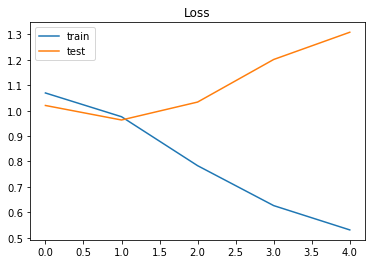

In [124]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

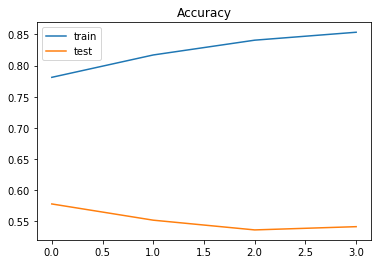

In [119]:

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()